In [3]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist

import tqdm

import warnings
warnings.filterwarnings('ignore')

from linear_operator.operators.dense_linear_operator import DenseLinearOperator
from linear_operator.operators import KroneckerProductLinearOperator, RootLinearOperator
from linear_operator.utils.interpolation import left_interp



In [4]:
from gpytorch import settings
from gpytorch.distributions import MultitaskMultivariateNormal, MultivariateNormal
from gpytorch.module import Module
from gpytorch.variational._variational_strategy import _VariationalStrategy

## lmc codes

In [5]:
class LMCSeparableKernel(gpytorch.kernels.Kernel):
    
    def __init__(self, kernel_list, **kwargs):
        
        super(LMCSeparableKernel, self).__init__(**kwargs)
        self.kernel_modules = torch.nn.ModuleList(kernel_list)
        self.init_kwargs = kwargs
    
    def forward(self, x1, x2, **params):
        
        # note: I might have to do x1.unsqueeze(-1), x2.unsqueeze(-1) when x1 dim == 0
        
        x1_dim = x1.shape
        x2_dim = x2.shape
        # print("params:", params)
        # print("init_x1_shape:", x1.shape)
        # print("init_x2_shape:", x2.shape)
        # if not (x1_dim[0] == 1 and x2_dim[0] == 1):
        #     x1 = x1.unsqueeze(0)
        #     x2 = x2.unsqueeze(0)
        # print("x_shape:", x1.shape)
        covar_x = self.kernel_modules[0].forward(x1, x2, **params)
        # print("kernel_0:", self.kernel_modules[0], "\n")
        # print("init_covar_x.shape:", covar_x.shape)
        i=1
        for k in self.kernel_modules[1:]:
            add_covar_x = k.forward(x1, x2, **params)
            if isinstance(add_covar_x, DenseLinearOperator):
                add_covar_x = add_covar_x.tensor
            # print(add_covar_x, "\n")
            covar_x = torch.vstack([covar_x, add_covar_x])
            # print(f"kernel_{i}:", k, "\n")
            # print("add_covar_x.shape:", add_covar_x.shape)
            i += 1
        # print("covar_x.shape:", covar_x.shape)
        return covar_x

In [6]:
def _select_lmc_coefficients(lmc_coefficients: torch.Tensor, indices: torch.LongTensor) -> torch.Tensor:
    """
    Given a list of indices for ... x N datapoints,
      select the row from lmc_coefficient that corresponds to each datapoint
    lmc_coefficients: torch.Tensor ... x num_latents x ... x num_tasks
    indices: torch.Tesnor ... x N
    """
    print("_select_lmc_coefficients has been called!!")
    batch_shape = torch.broadcast_shapes(lmc_coefficients.shape[:-1], indices.shape[:-1])

    # We will use the left_interp helper to do the indexing
    lmc_coefficients = lmc_coefficients.expand(*batch_shape, lmc_coefficients.shape[-1])[..., None]
    indices = indices.expand(*batch_shape, indices.shape[-1])[..., None]
    res = left_interp(
        indices,
        torch.ones(indices.shape, dtype=torch.long, device=indices.device),
        lmc_coefficients,
    ).squeeze(-1)
    return res


class LMCVariationalStrategy(_VariationalStrategy):
    r"""
    LMCVariationalStrategy is an implementation of the "Linear Model of Coregionalization"
    for multitask GPs. This model assumes that there are :math:`Q` latent functions
    :math:`\mathbf g(\cdot) = [g^{(1)}(\cdot), \ldots, g^{(q)}(\cdot)]`,
    each of which is modelled by a GP.
    The output functions (tasks) are linear combination of the latent functions:
    .. math::
        f_{\text{task } i}( \mathbf x) = \sum_{q=1}^Q a_i^{(q)} g^{(q)} ( \mathbf x )
    LMCVariationalStrategy wraps an existing :obj:`~gpytorch.variational.VariationalStrategy`.
    The output will either be a :obj:`~gpytorch.distributions.MultitaskMultivariateNormal` distribution
    (if we wish to evaluate all tasks for each input) or a :obj:`~gpytorch.distributions.MultivariateNormal`
    (if we wish to evaluate a single task for each input).
    The base variational strategy is assumed to operate on a multi-batch of GPs, where one
    of the batch dimensions corresponds to the latent function dimension.
    .. note::
        The batch shape of the base :obj:`~gpytorch.variational.VariationalStrategy` does not
        necessarily have to correspond to the batch shape of the underlying GP objects.
        For example, if the base variational strategy has a batch shape of `[3]` (corresponding
        to 3 latent functions), the GP kernel object could have a batch shape of `[3]` or no
        batch shape. This would correspond to each of the latent functions having different kernels
        or the same kernel, respectivly.
    Example:
        >>> class LMCMultitaskGP(gpytorch.models.ApproximateGP):
        >>>     '''
        >>>     3 latent functions
        >>>     5 output dimensions (tasks)
        >>>     '''
        >>>     def __init__(self):
        >>>         # Each latent function shares the same inducing points
        >>>         # We'll have 32 inducing points, and let's assume the input dimensionality is 2
        >>>         inducing_points = torch.randn(32, 2)
        >>>
        >>>         # The variational parameters have a batch_shape of [3] - for 3 latent functions
        >>>         variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
        >>>             inducing_points.size(-1), batch_shape=torch.Size([3]),
        >>>         )
        >>>         variational_strategy = gpytorch.variational.LMCVariationalStrategy(
        >>>             gpytorch.variational.VariationalStrategy(
        >>>                 self, inducing_points, variational_distribution, learn_inducing_locations=True,
        >>>             ),
        >>>             num_tasks=5,
        >>>             num_latents=3,
        >>>             latent_dim=-1,
        >>>         )
        >>>
        >>>         # Each latent function has its own mean/kernel function
        >>>         super().__init__(variational_strategy)
        >>>         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([3]))
        >>>         self.covar_module = gpytorch.kernels.ScaleKernel(
        >>>             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([3])),
        >>>             batch_shape=torch.Size([3]),
        >>>         )
        >>>
    :param ~gpytorch.variational.VariationalStrategy base_variational_strategy: Base variational strategy
    :param int num_tasks: The total number of tasks (output functions)
    :param int num_latents: The total number of latent functions in each group
    :param latent_dim: (Default: -1) Which batch dimension corresponds to the latent function batch.
        **Must be negative indexed**
    :type latent_dim: `int` < 0
    """

    def __init__(
        self,
        base_variational_strategy,
        num_tasks,
        num_latents=1,
        latent_dim=-1,
        jitter_val=None,
    ):
        Module.__init__(self)
        self.base_variational_strategy = base_variational_strategy
        self.num_tasks = num_tasks
        batch_shape = self.base_variational_strategy._variational_distribution.batch_shape
        
        # Added latent dist
        self.latent_dist = None

        # Check if no functions
        if latent_dim >= 0:
            raise RuntimeError(f"latent_dim must be a negative indexed batch dimension: got {latent_dim}.")
        if not (batch_shape[latent_dim] == num_latents or batch_shape[latent_dim] == 1):
            raise RuntimeError(
                f"Mismatch in num_latents: got a variational distribution of batch shape {batch_shape}, "
                f"expected the function dim {latent_dim} to be {num_latents}."
            )
        self.num_latents = num_latents
        self.latent_dim = latent_dim

        # Make the batch_shape
        self.batch_shape = list(batch_shape)
        del self.batch_shape[self.latent_dim]
        self.batch_shape = torch.Size(self.batch_shape)

        # LCM coefficients
        lmc_coefficients = torch.randn(*batch_shape, self.num_tasks)
        self.register_parameter("lmc_coefficients", torch.nn.Parameter(lmc_coefficients))

        if jitter_val is None:
            self.jitter_val = settings.variational_cholesky_jitter.value(
                self.base_variational_strategy.inducing_points.dtype
            )
        else:
            self.jitter_val = jitter_val
            

    @property
    def prior_distribution(self):
        return self.base_variational_strategy.prior_distribution

    @property
    def variational_distribution(self):
        return self.base_variational_strategy.variational_distribution

    @property
    def variational_params_initialized(self):
        return self.base_variational_strategy.variational_params_initialized

    def kl_divergence(self):
        return super().kl_divergence().sum(dim=self.latent_dim)

    def __call__(self, x, task_indices=None, prior=False, **kwargs):
        r"""
        Computes the variational (or prior) distribution
        :math:`q( \mathbf f \mid \mathbf X)` (or :math:`p( \mathbf f \mid \mathbf X)`).
        There are two modes:
        1.  Compute **all tasks** for all inputs.
            If this is the case, the task_indices attribute should be None.
            The return type will be a (... x N x num_tasks)
            :class:`~gpytorch.distributions.MultitaskMultivariateNormal`.
        2.  Compute **one task** per inputs.
            If this is the case, the (... x N) task_indices tensor should contain
            the indices of each input's assigned task.
            The return type will be a (... x N)
            :class:`~gpytorch.distributions.MultivariateNormal`.
        :param x: Input locations to evaluate variational strategy
        :type x: torch.Tensor (... x N x D)
        :param task_indices: (Default: None) Task index associated with each input.
            If this **is not** provided, then the returned distribution evaluates every input on every task
            (returns :class:`~gpytorch.distributions.MultitaskMultivariateNormal`).
            If this **is** provided, then the returned distribution evaluates each input only on its assigned task.
            (returns :class:`~gpytorch.distributions.MultivariateNormal`).
        :type task_indices: torch.Tensor (... x N), optional
        :param prior: (Default: False) If False, returns the variational distribution
            :math:`q( \mathbf f \mid \mathbf X)`.
            If True, returns the prior distribution
            :math:`p( \mathbf f \mid \mathbf X)`.
        :type prior: bool
        :return: :math:`q( \mathbf f \mid \mathbf X)` (or the prior),
            either for all tasks (if `task_indices == None`)
            or for a specific task (if `task_indices != None`).
        :rtype: ~gpytorch.distributions.MultitaskMultivariateNormal (... x N x num_tasks)
            or ~gpytorch.distributions.MultivariateNormal (... x N)
        """
        self.latent_dist = self.base_variational_strategy(x, prior=prior, **kwargs)
        num_batch = len(self.latent_dist.batch_shape)
        latent_dim = num_batch + self.latent_dim

        if task_indices is None:
            print("task_indices is None!")
            num_dim = num_batch + len(self.latent_dist.event_shape)

            # Every data point will get an output for each task
            # Therefore, we will set up the lmc_coefficients shape for a matmul
            lmc_coefficients = self.lmc_coefficients.expand(*self.latent_dist.batch_shape, self.lmc_coefficients.size(-1))

            # Mean: ... x N x num_tasks
            latent_mean = self.latent_dist.mean.permute(*range(0, latent_dim), *range(latent_dim + 1, num_dim), latent_dim)
            mean = latent_mean @ lmc_coefficients.permute(
                *range(0, latent_dim), *range(latent_dim + 1, num_dim - 1), latent_dim, -1
            )

            # Covar: ... x (N x num_tasks) x (N x num_tasks)
            latent_covar = self.latent_dist.lazy_covariance_matrix
            lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
            covar = KroneckerProductLinearOperator(latent_covar, lmc_factor).sum(latent_dim)
            # Add a bit of jitter to make the covar PD
            covar = covar.add_jitter(self.jitter_val)

            # Done!
            function_dist = MultitaskMultivariateNormal(mean, covar)

        else:
            print("task_indices is NOT none!!!")
            # Each data point will get a single output corresponding to a single task
            # Therefore, we will select the appropriate lmc coefficients for each task
            
            # Issue begins somewhere here
            
            lmc_coefficients = _select_lmc_coefficients(self.lmc_coefficients, task_indices)
            
            # Mean: ... x N
            mean = (self.latent_dist.mean * lmc_coefficients).sum(latent_dim)

            # Covar: ... x N x N
            latent_covar = self.latent_dist.lazy_covariance_matrix
            lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
            covar = (latent_covar * lmc_factor).sum(latent_dim)
            # Add a bit of jitter to make the covar PD
            covar = covar.add_jitter(self.jitter_val)

            # Done!
            function_dist = MultivariateNormal(mean, covar)

        return function_dist

In [7]:
# def _select_lmc_coefficients(lmc_coefficients: torch.Tensor, indices: torch.LongTensor) -> torch.Tensor:
#     """
#     Given a list of indices for ... x N datapoints,
#       select the row from lmc_coefficient that corresponds to each datapoint

#     lmc_coefficients: torch.Tensor ... x num_latents x ... x num_tasks
#     indices: torch.Tesnor ... x N
#     """
#     batch_shape = torch.broadcast_shapes(lmc_coefficients.shape[:-1], indices.shape[:-1])

#     # We will use the left_interp helper to do the indexing
#     lmc_coefficients = lmc_coefficients.expand(*batch_shape, lmc_coefficients.shape[-1])[..., None]
#     indices = indices.expand(*batch_shape, indices.shape[-1])[..., None]
#     res = left_interp(
#         indices,
#         torch.ones(indices.shape, dtype=torch.long, device=indices.device),
#         lmc_coefficients,
#     ).squeeze(-1)
#     return res


# class LMCVariationalStrategy(_VariationalStrategy):
#     r"""
#     LMCVariationalStrategy is an implementation of the "Linear Model of Coregionalization"
#     for multitask GPs. This model assumes that there are :math:`Q` latent functions
#     :math:`\mathbf g(\cdot) = [g^{(1)}(\cdot), \ldots, g^{(q)}(\cdot)]`,
#     each of which is modelled by a GP.
#     The output functions (tasks) are linear combination of the latent functions:

#     .. math::

#         f_{\text{task } i}( \mathbf x) = \sum_{q=1}^Q a_i^{(q)} g^{(q)} ( \mathbf x )

#     LMCVariationalStrategy wraps an existing :obj:`~gpytorch.variational.VariationalStrategy`.
#     The output will either be a :obj:`~gpytorch.distributions.MultitaskMultivariateNormal` distribution
#     (if we wish to evaluate all tasks for each input) or a :obj:`~gpytorch.distributions.MultivariateNormal`
#     (if we wish to evaluate a single task for each input).

#     The base variational strategy is assumed to operate on a multi-batch of GPs, where one
#     of the batch dimensions corresponds to the latent function dimension.

#     .. note::

#         The batch shape of the base :obj:`~gpytorch.variational.VariationalStrategy` does not
#         necessarily have to correspond to the batch shape of the underlying GP objects.

#         For example, if the base variational strategy has a batch shape of `[3]` (corresponding
#         to 3 latent functions), the GP kernel object could have a batch shape of `[3]` or no
#         batch shape. This would correspond to each of the latent functions having different kernels
#         or the same kernel, respectivly.

#     Example:
#         >>> class LMCMultitaskGP(gpytorch.models.ApproximateGP):
#         >>>     '''
#         >>>     3 latent functions
#         >>>     5 output dimensions (tasks)
#         >>>     '''
#         >>>     def __init__(self):
#         >>>         # Each latent function shares the same inducing points
#         >>>         # We'll have 32 inducing points, and let's assume the input dimensionality is 2
#         >>>         inducing_points = torch.randn(32, 2)
#         >>>
#         >>>         # The variational parameters have a batch_shape of [3] - for 3 latent functions
#         >>>         variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
#         >>>             inducing_points.size(-1), batch_shape=torch.Size([3]),
#         >>>         )
#         >>>         variational_strategy = gpytorch.variational.LMCVariationalStrategy(
#         >>>             gpytorch.variational.VariationalStrategy(
#         >>>                 inducing_points, variational_distribution, learn_inducing_locations=True,
#         >>>             ),
#         >>>             num_tasks=5,
#         >>>             num_latents=3,
#         >>>             latent_dim=0,
#         >>>         )
#         >>>
#         >>>         # Each latent function has its own mean/kernel function
#         >>>         super().__init__(variational_strategy)
#         >>>         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([3]))
#         >>>         self.covar_module = gpytorch.kernels.ScaleKernel(
#         >>>             gpytorch.kernels.RBFKernel(batch_shape=torch.Size([3])),
#         >>>             batch_shape=torch.Size([3]),
#         >>>         )
#         >>>

#     :param ~gpytorch.variational.VariationalStrategy base_variational_strategy: Base variational strategy
#     :param int num_tasks: The total number of tasks (output functions)
#     :param int num_latents: The total number of latent functions in each group
#     :param latent_dim: (Default: -1) Which batch dimension corresponds to the latent function batch.
#         **Must be negative indexed**
#     :type latent_dim: `int` < 0
#     """

#     def __init__(
#         self,
#         base_variational_strategy,
#         num_tasks,
#         num_latents=1,
#         latent_dim=-1,
#     ):
#         Module.__init__(self)
#         self.base_variational_strategy = base_variational_strategy
#         self.num_tasks = num_tasks
#         batch_shape = self.base_variational_strategy._variational_distribution.batch_shape

#         # Check if no functions
#         if latent_dim >= 0:
#             raise RuntimeError(f"latent_dim must be a negative indexed batch dimension: got {latent_dim}.")
#         if not (batch_shape[latent_dim] == num_latents or batch_shape[latent_dim] == 1):
#             raise RuntimeError(
#                 f"Mismatch in num_latents: got a variational distribution of batch shape {batch_shape}, "
#                 f"expected the function dim {latent_dim} to be {num_latents}."
#             )
#         self.num_latents = num_latents
#         self.latent_dim = latent_dim
#         self.latent_dist = None

#         # Make the batch_shape
#         self.batch_shape = list(batch_shape)
#         del self.batch_shape[self.latent_dim]
#         self.batch_shape = torch.Size(self.batch_shape)

#         # LCM coefficients
#         lmc_coefficients = torch.randn(*batch_shape, self.num_tasks)
#         self.register_parameter("lmc_coefficients", torch.nn.Parameter(lmc_coefficients))

#     @property
#     def prior_distribution(self):
#         return self.base_variational_strategy.prior_distribution

#     @property
#     def variational_distribution(self):
#         return self.base_variational_strategy.variational_distribution

#     @property
#     def variational_params_initialized(self):
#         return self.base_variational_strategy.variational_params_initialized

#     def kl_divergence(self):
#         return super().kl_divergence().sum(dim=self.latent_dim)

#     def __call__(self, x, task_indices=None, prior=False, **kwargs):
#         r"""
#         Computes the variational (or prior) distribution
#         :math:`q( \mathbf f \mid \mathbf X)` (or :math:`p( \mathbf f \mid \mathbf X)`).
#         There are two modes:

#         1.  Compute **all tasks** for all inputs.
#             If this is the case, the task_indices attribute should be None.
#             The return type will be a (... x N x num_tasks)
#             :class:`~gpytorch.distributions.MultitaskMultivariateNormal`.
#         2.  Compute **one task** per inputs.
#             If this is the case, the (... x N) task_indices tensor should contain
#             the indices of each input's assigned task.
#             The return type will be a (... x N)
#             :class:`~gpytorch.distributions.MultivariateNormal`.

#         :param x: Input locations to evaluate variational strategy
#         :type x: torch.Tensor (... x N x D)
#         :param task_indices: (Default: None) Task index associated with each input.
#             If this **is not** provided, then the returned distribution evaluates every input on every task
#             (returns :class:`~gpytorch.distributions.MultitaskMultivariateNormal`).
#             If this **is** provided, then the returned distribution evaluates each input only on its assigned task.
#             (returns :class:`~gpytorch.distributions.MultivariateNormal`).
#         :type task_indices: torch.Tensor (... x N), optional
#         :param prior: (Default: False) If False, returns the variational distribution
#             :math:`q( \mathbf f \mid \mathbf X)`.
#             If True, returns the prior distribution
#             :math:`p( \mathbf f \mid \mathbf X)`.
#         :type prior: bool
#         :return: :math:`q( \mathbf f \mid \mathbf X)` (or the prior),
#             either for all tasks (if `task_indices == None`)
#             or for a specific task (if `task_indices != None`).
#         :rtype: ~gpytorch.distributions.MultitaskMultivariateNormal (... x N x num_tasks)
#             or ~gpytorch.distributions.MultivariateNormal (... x N)
#         """
#         self.latent_dist = self.base_variational_strategy(x, prior=prior, **kwargs)
#         num_batch = len(self.latent_dist.batch_shape)
#         latent_dim = num_batch + self.latent_dim

#         if task_indices is None:
#             num_dim = num_batch + len(self.latent_dist.event_shape)

#             # Every data point will get an output for each task
#             # Therefore, we will set up the lmc_coefficients shape for a matmul
#             lmc_coefficients = self.lmc_coefficients.expand(*self.latent_dist.batch_shape, self.lmc_coefficients.size(-1))

#             # Mean: ... x N x num_tasks
#             latent_mean = self.latent_dist.mean.permute(*range(0, latent_dim), *range(latent_dim + 1, num_dim), latent_dim)
#             mean = latent_mean @ lmc_coefficients.permute(
#                 *range(0, latent_dim), *range(latent_dim + 1, num_dim - 1), latent_dim, -1
#             )

#             # Covar: ... x (N x num_tasks) x (N x num_tasks)
#             latent_covar = self.latent_dist.lazy_covariance_matrix
#             lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
#             covar = KroneckerProductLinearOperator(latent_covar, lmc_factor).sum(latent_dim)
#             # Add a bit of jitter to make the covar PD
#             covar = covar.add_jitter(settings.cholesky_jitter.value(dtype=mean.dtype))

#             # Done!
#             function_dist = MultitaskMultivariateNormal(mean, covar)

#         else:
#             # Each data point will get a single output corresponding to a single task
#             # Therefore, we will select the appropriate lmc coefficients for each task
#             lmc_coefficients = _select_lmc_coefficients(self.lmc_coefficients, task_indices)

#             # Mean: ... x N
#             mean = (self.latent_dist.mean * lmc_coefficients).sum(latent_dim)

#             # Covar: ... x N x N
#             latent_covar = self.latent_dist.lazy_covariance_matrix
#             lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))
#             covar = (latent_covar * lmc_factor).sum(latent_dim)
#             # Add a bit of jitter to make the covar PD
#             covar = covar.add_jitter(settings.cholesky_jitter.value(dtype=mean.dtype))

#             # Done!
#             function_dist = MultivariateNormal(mean, covar)

#         return function_dist

## Setup scenario

In [8]:
N_1 = 400
N_2 = 500
X = torch.linspace(0, 1, 1000)

obs_idx_x1 = torch.concat([torch.randint(low=0, high=250, size=(int(N_1/2),)).sort()[0],
                           torch.randint(low=500, high=1000, size=(int(N_1/2),)).sort()[0]])

obs_idx_x3 = obs_idx_x1

obs_idx_x2 = torch.concat([torch.randint(low=0, high=600, size=(int(N_2/2),)).sort()[0],
                         torch.randint(low=850, high=1000, size=(int(N_2/2),)).sort()[0]])

obs_idx_x4 = obs_idx_x2

train_i_task1 = torch.full((obs_idx_x1.shape[0],1), dtype=torch.long, fill_value=0)
train_i_task2 = torch.full((obs_idx_x2.shape[0],1), dtype=torch.long, fill_value=1)
train_i_task3 = torch.full((obs_idx_x3.shape[0],1), dtype=torch.long, fill_value=2)
train_i_task4 = torch.full((obs_idx_x4.shape[0],1), dtype=torch.long, fill_value=3)

train_x1 = X[obs_idx_x1]
train_x2 = X[obs_idx_x2]
train_x3 = X[obs_idx_x3]
train_x4 = X[obs_idx_x4]

N = obs_idx_x1.size(-1) + obs_idx_x2.size(-1) + obs_idx_x3.size(-1) + obs_idx_x4.size(-1)

full_train_x = torch.cat([train_x1, train_x2, train_x3, train_x4])
full_train_i = torch.cat([train_i_task1, train_i_task2, train_i_task3, train_i_task4])

In [9]:
class ExactGP(gpytorch.models.ExactGP):
            
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
input_dim = 1
train_x = None
train_y = None

# initialise the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=input_dim))
kernel2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(ard_num_dims=input_dim))
model1 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel1)
model2 = ExactGP(train_x=train_x, train_y=train_y, likelihood=likelihood, kernel=kernel2)

hypers = [
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor(.5),
    }, 
    {
        'likelihood.noise_covar.noise': torch.tensor(1),
        'covar_module.outputscale': torch.tensor(1.),
        'covar_module.base_kernel.lengthscale': torch.tensor(.8),
        'covar_module.base_kernel.period_length': torch.tensor(.25)
    }
]

# non-surface
N = 1000
torch.manual_seed(55)
Y = torch.empty((N,2))

# # surface
# N = 100
# x1 = torch.linspace(0, 1, N)
# x2 = torch.linspace(0, 1, N)
# x1_grid, x2_grid = torch.meshgrid([x1, x2])
# X = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))
# Y = torch.empty((N**2,2))

A = torch.tensor([
    [-.25, 2.1, .91, -.05, -.05, -0.25], # A_1
    [-.52, -0.05, .25, 1.1, 1.1, .1], # A_2
]).T

torch.manual_seed(55)
model1.initialize(**hypers[0])
model1.eval()
with gpytorch.settings.prior_mode(True):
    Y[:,0] = model1(X).sample()
    
torch.manual_seed(2)
model2.initialize(**hypers[1])
model2.eval()
with gpytorch.settings.prior_mode(True):
    Y[:,1] = model2(X).sample()
    

torch.manual_seed(55)
f_11 = Y @ A[0,:]
f_12 = Y @ A[1,:]
test_y1 = torch.normal(f_11, f_12.exp())
train_y1 = test_y1[obs_idx_x1]

torch.manual_seed(55)
f_21 = Y @ A[2,:]
test_y2 = dist.Poisson(f_21.exp())()
train_y2 = test_y2[obs_idx_x2]

torch.manual_seed(55)
f_31 = Y @ A[3,:]
test_y3 = dist.Poisson(f_31.exp())()
train_y3 = test_y3[obs_idx_x3]

torch.manual_seed(55)
f_41 = Y @ A[4,:]
f_42 = Y @ A[5,:]
test_y4 = torch.normal(f_41, f_42.exp())
train_y4 = test_y4[obs_idx_x4]

full_train_y = torch.cat([train_y1, train_y2, train_y3, train_y4])

<AxesSubplot:>

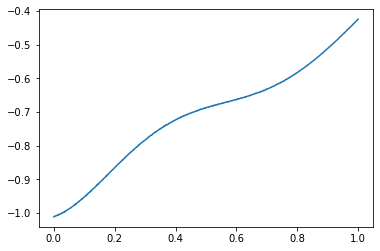

In [10]:
sns.lineplot(X, Y[:,0])

<AxesSubplot:>

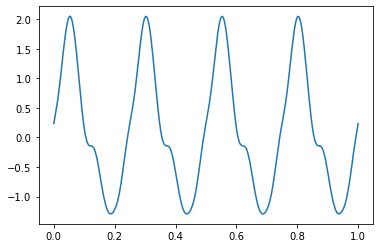

In [11]:
sns.lineplot(X, Y[:,1])

<AxesSubplot:>

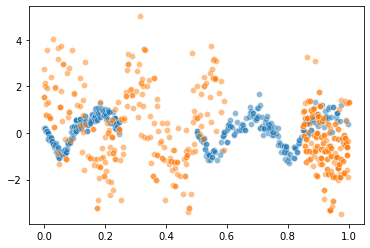

In [12]:
sns.scatterplot(train_x1, train_y1, alpha=.5)
sns.scatterplot(train_x4, train_y4, alpha=.5)

<AxesSubplot:>

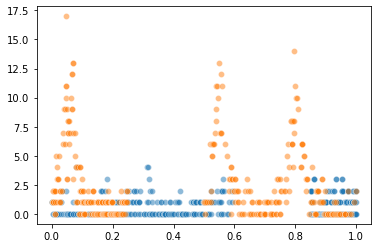

In [13]:
sns.scatterplot(train_x2, train_y2, alpha=.5)
sns.scatterplot(train_x3, train_y3, alpha=.5)

## Running model

In [14]:
test_x = X

if torch.cuda.is_available():
    full_train_x, full_train_y, test_x, = full_train_x.cuda(), full_train_y.cuda(), test_x.cuda()

Notes to make task_indices work:

- ```function_dist = self.pyro_guide(x)``` to include ```task_indices``` arg
- ```function_dist = self.pyro_model(x)``` to include ```task_indices``` arg
- check if ```function_dist.batch_shape``` and ```function_dist.event_shape``` for ```function_dist``` changes as a result adding in ```task_indices```
- setup train_x and task_indices as per [tutorial](https://docs.gpytorch.ai/en/stable/examples/03_Multitask_Exact_GPs/Hadamard_Multitask_GP_Regression.html)
- Do I need to make input a tuple? ```model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)```


To test

- Size for each N_i are different

In [32]:
class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, train_x, num_lpf, likelihoods, kernels, name_prefix="lmc_mogp", num_inducing=100, jitter_val=1e-06):
        
        self.name_prefix = name_prefix
        self.likelihoods = likelihoods
        self.n_task_indices = len(likelihoods)
        num_latents = len(kernels)
        
        input_dim = 1
        if train_x.dim() > 1:
            input_dim = train_x.size(-1)
        
        # Let's use a different set of inducing points for each latent function
        inducing_points = torch.linspace(0, 1, num_inducing).expand(1, input_dim, num_inducing).permute(0,2,1)
        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        base_variational_strategy = gpytorch.variational.VariationalStrategy(
                self, inducing_points, 
                variational_distribution, # variational distribution over the inducing point values, q(u),
                learn_inducing_locations=True,
            )
        
        # __call__ function calls variational_strategy instance of LMCVariationalStrategy
        variational_strategy = LMCVariationalStrategy(
            base_variational_strategy=base_variational_strategy,
            num_tasks=num_lpf,
            num_latents=num_latents,
            latent_dim=-1,
            jitter_val=jitter_val
        )
        
        super().__init__(variational_strategy=variational_strategy)
        
        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
        self.covar_module = LMCSeparableKernel(kernels, batch_shape=torch.Size([num_latents]))

    def forward(self, x, task_indices=torch.LongTensor([0, 1, 3, 2, 2])):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        print("task_indices:", task_indices)
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
    def compute_likelihoods(self, y, function_dist, likelihoods):
        
        # if no task_indices
        # assert train_y.size(-1) == len(likelihoods), f"Size of output y does not much size of likelihoods list. \
        #     Input size is ({train_y.size(-1)}, {len(likelihoods)})."
        
        # if task_indices
        assert train_y.size(-1) == len(likelihoods), f"Size of output y does not much size of likelihoods list. \
            Input size is ({train_y.size(-1)}, {len(likelihoods)})."
        
        
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
            j = 0
            for i, l in enumerate(likelihoods):
                if l == "HetGaussian":
                    pyro.sample(
                        self.name_prefix + ".y_" + str(i),
                        dist.Normal(f[..., j], f[...,j+1].exp()).to_event(1),
                        obs=y[...,i]
                    )
                    j += 2
                elif l == "Poisson":
                    pyro.sample(
                        self.name_prefix + ".y_" + str(i),
                        dist.Poisson(f[...,j].exp()).to_event(1),
                        obs=y[...,i]
                    )
                    j += 1
                elif l == "Bernoulli":
                    pyro.sample(
                        self.name_prefix + ".y_" + str(i),
                        dist.Bernoulli(logits=f[...,j]).to_event(1),
                        obs=y[...,i]
                    )
                    j += 1
                elif l == "Categorical":
                    n_categories = y[...,i].max().to(torch.long).item() + 1
                    pyro.sample(
                        self.name_prefix + ".y_" + str(i),
                        dist.Categorical(logits=f[...,j:(n_categories+1)]).to_event(1),
                        obs=y[...,i]
                    )
                    j += n_categories
                    
            assert f.size(-1) == j, f"Not all latent parameter functions (LPF) were used as inputs to likelihood distributions. \
                Total LPF is {f.size(-1)}, however only {j} of the LPFs were used as inputs."
    
    @pyro.poutine.scale(scale=1.0/(full_train_y.numel()))
    def guide(self, x, y, task):
         # Get q(f) - variational (guide) distribution of latent function
        function_dist = self.pyro_guide(x)
        print("guide function_dist.batch_shape:", function_dist.batch_shape) # torch.Size([1000])
        print("guide function_dist.event_shape:", function_dist.event_shape) # torch.Size([6])
        with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
            # Sample from latent function distribution
            f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
    
    @pyro.poutine.scale(scale=1.0/(full_train_y.numel()))
    def model(self, x, y, task):
        pyro.module(self.name_prefix + ".gp", self)

        # Get p(f) - prior distribution of latent function
        function_dist = self.pyro_model(x)        
        print("model function_dist.batch_shape:", function_dist.batch_shape) # torch.Size([1000])
        print("model function_dist.event_shape:", function_dist.event_shape) # torch.Size([6])
        self.compute_likelihoods(y, function_dist, self.likelihoods)

In [33]:
# class MultitaskGPModel(gpytorch.models.ApproximateGP):
#     def __init__(self, num_tasks, input_dim, name_prefix="lmc_mogp", kernel_type="rbf", kernel_list=None, num_inducing=200):
        
#         self.name_prefix = name_prefix
#         num_latents = len(kernel_list)
        
#         # inducing_points = torch.linspace(0, 1, 500)
#         inducing_points = torch.linspace(0, 1, num_inducing).expand(1, input_dim, num_inducing).permute(0,2,1)
#         print("inducing_points.shape:", inducing_points.shape)
#         variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(
#             inducing_points.size(-2), batch_shape=torch.Size([num_latents])
#         )
#         print("variational_distribution.shape:", variational_distribution.shape())

#         base_variational_strategy = gpytorch.variational.VariationalStrategy(
#                 self, inducing_points, 
#                 variational_distribution, # variational distribution over the inducing point values, q(u),
#                 learn_inducing_locations=True
#             )
        
#         variational_strategy = LMCVariationalStrategy(
#             base_variational_strategy=base_variational_strategy,
#             num_tasks=num_tasks,
#             num_latents=num_latents,
#             latent_dim=-1
#         )
        
#         super().__init__(variational_strategy=variational_strategy)
        
#         if kernel_type == "matern":
#             kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(batch_shape=torch.Size([num_latents])), batch_shape=torch.Size([num_latents]))
#         elif kernel_type == "rbfmatern":
#             rbf_kernel = gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents]))
#             matern_kernel = gpytorch.kernels.MaternKernel(batch_shape=torch.Size([num_latents]))
#             kernel = gpytorch.kernels.AdditiveKernel(rbf_kernel, matern_kernel)
#         elif kernel_type == "wtf":
#             kernel = gpytorch.kernels.ScaleKernel(
#                                 gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
#                                 batch_shape=torch.Size([num_latents])) + \
#                         gpytorch.kernels.ScaleKernel(
#                             gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
#                             batch_shape=torch.Size([num_latents]))
#         elif kernel_type == "wtf_try_again":
#             kernel = gpytorch.kernels.LCMKernel(
#                             [gpytorch.kernels.RBFKernel(),
#                             gpytorch.kernels.PeriodicKernel()],
#                             num_tasks=num_tasks
#                         )
#         elif kernel_type == "lmc":
#             kernel = LMCSeparableKernel(kernel_list, batch_shape=torch.Size([num_latents]))
#         else:
#             kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
#                                                   batch_shape=torch.Size([num_latents]))
#         # The mean and covariance modules should be marked as batch
#         # so we learn a different set of hyperparameters
#         self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))
#         self.covar_module = kernel

#     def forward(self, x):
#         # The forward function should be written as if we were dealing with each output
#         # dimension in batch
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
#     @pyro.poutine.scale(scale=1.0/(3000.0))
#     def guide(self, x, y):
#          # Get q(f) - variational (guide) distribution of latent function
#         function_dist = self.pyro_guide(x)

#         # Use a plate here to mark conditional independencies
#         # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#         with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#             # Sample from latent function distribution
#             f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
        
        
#     @pyro.poutine.scale(scale=1.0/(3000.0))
#     def model(self, x, y):
#         pyro.module(self.name_prefix + ".gp", self)

#         # Get p(f) - prior distribution of latent function
#         function_dist = self.pyro_model(x)

#         # Use a plate here to mark conditional independencies
#         # with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#         with pyro.plate(self.name_prefix + ".data_plate", dim=-1):
#             # Sample from latent function distribution
#             f = pyro.sample(self.name_prefix + ".f(x)", function_dist)
            
#             # print(function_samples)
#             # Sample from observed distribution
#             pyro.sample(
#                 self.name_prefix + ".y_1",
#                 dist.Normal(f[...,0], f[...,1].exp()).to_event(1),
#                 obs=y[...,0]
#             )
            
#             pyro.sample(
#                 self.name_prefix + ".y_2",
#                 dist.Poisson(f[...,2].exp()).to_event(1),
#                 obs=y[...,1]
#             )
            
#             pyro.sample(
#                 self.name_prefix + ".y_3",
#                 dist.Poisson(f[...,3].exp()).to_event(1),
#                 obs=y[...,2]
#             )
            
#             pyro.sample(
#                 self.name_prefix + ".y_4",
#                 dist.Normal(f[...,4], f[...,5].exp()).to_event(1),
#                 obs=y[...,3]
#             )

In [34]:
# model = MultitaskGPModel(num_tasks=6, num_latents=2, kernel_type="rbf")
lengthscale_prior = gpytorch.priors.GammaPrior(2.0, 4.0)

kernel_list0 = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)),
               gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]

kernel_list0_1 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
               gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior)]

kernel_list1 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.ProductKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]

kernel_list2 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.ProductKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]


kernel_list3 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.AdditiveKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior))]

kernel_list4 = [gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
               gpytorch.kernels.AdditiveKernel(gpytorch.kernels.MaternKernel(lengthscale_prior=lengthscale_prior), 
                                              gpytorch.kernels.ProductKernel(
                                                  gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior), 
                                                  gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior)))]

kernel_list5 = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)), 
               gpytorch.kernels.ProductKernel(gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel(lengthscale_prior=lengthscale_prior)), 
                                              gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior)))]

kernel_list6 = [gpytorch.kernels.ProductKernel(gpytorch.kernels.PeriodicKernel(lengthscale_prior=lengthscale_prior),
                                               gpytorch.kernels.AdditiveKernel(gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior),
                                                                               gpytorch.kernels.RBFKernel(lengthscale_prior=lengthscale_prior)))]

likelihoods = ["HetGaussian", "Poisson", "Poisson", "HetGaussian"]
model = MultitaskGPModel(full_train_x, num_lpf=6, likelihoods=likelihoods, kernels=kernel_list0, num_inducing=100, jitter_val = 1e-9)

if torch.cuda.is_available():
    model = model.cuda()

In [36]:
pyro.clear_param_store()

# num_iter = 2000
num_iter = 1200
num_particles = 10

# If getting Matrix not PSD error try:
# - decreasing gamma = 1e-3 / decreasing final_lr = 1e-3 (for fast training, try final_lr = 1e-2)

initial_lr = 1e-1
final_lr = 1e-3
gamma = final_lr / initial_lr  # final learning rate will be gamma * initial_l|r
lrd = gamma ** (1 / num_iter) # learning rate decay

optimizer = pyro.optim.ClippedAdam({
    'lr': initial_lr, 
    'lrd': lrd,
    'betas': (0.95, 0.999)})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
# elbo = pyro.infer.Trace_ELBO(vectorize_particles=True, retain_graph=True)
svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter), desc="Epoch")
loss_array = np.zeros(num_iter)
for i in iterator:
    model.zero_grad()
    loss = svi.step(full_train_x, full_train_y, None)
    loss_array[i] = loss
    iterator.set_postfix(loss=loss)

Epoch:   0%|          | 0/1200 [00:00<?, ?it/s]

task_indices: tensor([0, 1, 3, 2, 2])
task_indices is None!
guide function_dist.batch_shape: torch.Size([1800])
guide function_dist.event_shape: torch.Size([6])
task_indices: tensor([0, 1, 3, 2, 2])
task_indices is None!
model function_dist.batch_shape: torch.Size([1800])
model function_dist.event_shape: torch.Size([6])


AttributeError: 'NoneType' object has no attribute 'size'

<AxesSubplot:>

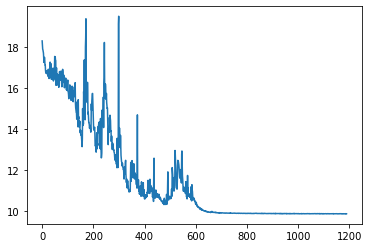

In [81]:
loss_start = 10
sns.lineplot(np.arange(0, len(loss_array) - loss_start), loss_array[loss_start:])

In [82]:
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]

    # Smooth the samples
    kernel = torch.full((1, 1, 5), fill_value=0.2)
    percentiles_samples = [
        torch.nn.functional.conv1d(percentile_sample.view(1, 1, -1), kernel, padding=2).view(-1)
        for percentile_sample in percentile_samples
    ]

    return percentile_samples

In [83]:
model.eval()

with torch.no_grad():
    output = model(test_x)

# Similarly get the 5th and 95th percentiles
samples = output(torch.Size([1000]))
mu_sim = model(test_x)()

lower, mean, upper = percentiles_from_samples(samples.cpu())
train_x, train_y, test_x = train_x.cpu(), train_y.cpu(), test_x.cpu()

# Draw some simulated y values
y_sim = torch.stack(
    [dist.Normal(mu_sim[:,0].detach(), mu_sim[:,1].detach().exp())(),
     dist.Poisson(mu_sim[:,2].detach().exp())(), 
     dist.Poisson(mu_sim[:,3].detach().exp())(), 
     dist.Normal(mu_sim[:,4].detach(), mu_sim[:,5].detach().exp())()],
    dim=-1
)

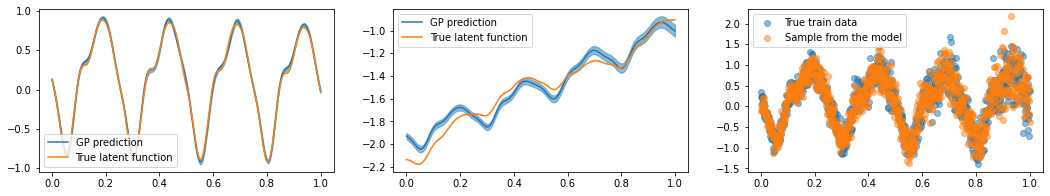

In [84]:
# visualize the result
fig, (*func, samp) = plt.subplots(1, 3, figsize=(18, 3))

for i,j in enumerate(range(2)):
    line, = func[i].plot(test_x, mean[:,j].detach().cpu().numpy(), label='GP prediction')
    func[i].fill_between(
        test_x, lower[:,j].squeeze().detach().cpu().numpy(),
        upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )
    f_plot = f_11 if i == 0 else f_12
    func[i].plot(test_x, f_plot, label='True latent function')
    func[i].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,0], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,0].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

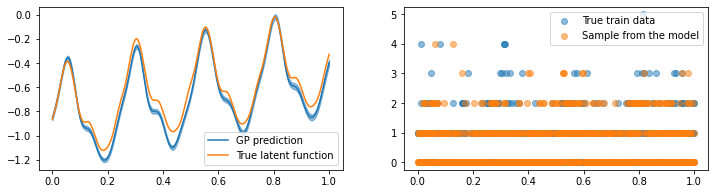

In [85]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,2].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,2].squeeze().detach().cpu().numpy(),
    upper[:,2].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_21, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,1], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,1].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

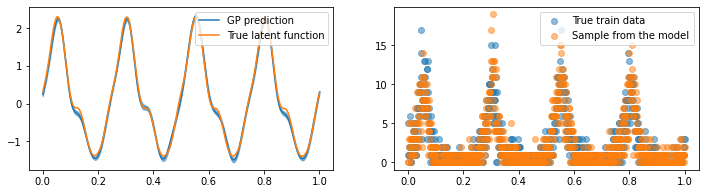

In [86]:
# visualize the result
fig, (func, samp) = plt.subplots(1, 2, figsize=(12, 3))
line, = func.plot(test_x, mean[:,3].detach().cpu().numpy(), label='GP prediction')
func.fill_between(
    test_x, lower[:,3].squeeze().detach().cpu().numpy(),
    upper[:,3].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
)

func.plot(test_x, f_31, label='True latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,2], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,2].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

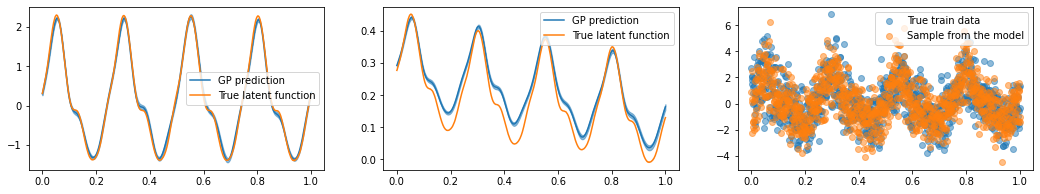

In [87]:
# visualize the result
fig, (*func, samp) = plt.subplots(1, 3, figsize=(18, 3))

for i,j in enumerate(range(4,6)):
    line, = func[i].plot(test_x, mean[:,j].detach().cpu().numpy(), label='GP prediction')
    func[i].fill_between(
        test_x, lower[:,j].squeeze().detach().cpu().numpy(),
        upper[:,j].squeeze().detach().cpu().numpy(), color=line.get_color(), alpha=0.5
    )
    f_plot = f_41 if i == 0 else f_42
    func[i].plot(test_x, f_plot, label='True latent function')
    func[i].legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) df (doubly stochastic)
samp.scatter(train_x, train_y[:,3], alpha = 0.5, label='True train data')
samp.scatter(train_x, y_sim[:,3].cpu().detach().numpy(), alpha=0.5, label='Sample from the model')
samp.legend()

## Testing the code

In [202]:
model.eval()

with torch.no_grad():
    latent_dist_draw = model.variational_strategy.latent_dist.sample(torch.Size([1000]))
    latent_dist_draw = latent_dist_draw.cpu()
    
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()
    test = model.variational_strategy.latent_dist

lower, mean, upper = percentiles_from_samples(latent_dist_draw)


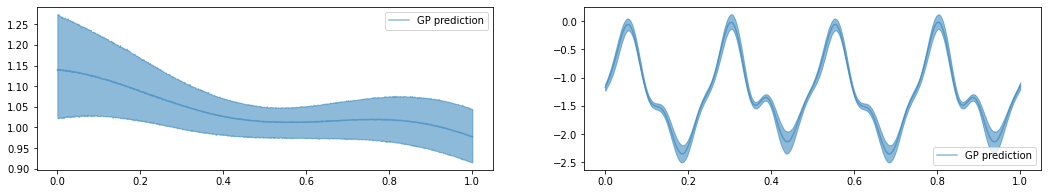

In [212]:
# visualize the result
fig, func = plt.subplots(1, latent_dist_draw.size(-2), figsize=(18, 3))

scale_adj = torch.tensor([-.8, .8]) # scale the true GP

for i in range(latent_dist_draw.size(-2)):
    line, = func[i].plot(test_x, mean[i,:], label='GP prediction', alpha=0.5)
    func[i].fill_between(
        test_x, lower[i,:],
        upper[i,:], alpha=0.5, color=line.get_color()
    )
    # func[i].plot(test_x, Y[:,i]*scale_adj[i], label='True latent function', alpha=0.5)
    func[i].legend()


In [586]:
x1 = torch.linspace(0, 1, 5)
x2 = torch.linspace(0, 1, 5)

x1_grid, x2_grid = torch.meshgrid([x1, x2])
X_grid = torch.cat(tuple(torch.dstack([x1_grid, x2_grid])))

In [587]:
X_grid[:,0].shape

torch.Size([25])

In [601]:
model.

MultivariateNormal(loc: torch.Size([2, 200]))

In [593]:
with torch.no_grad():
    test = model(X_grid.cuda())

In [599]:
test.

<bound method Distribution.score_parts of MultitaskMultivariateNormal(loc: torch.Size([150]))>

In [588]:
test(X_grid)

TypeError: unsupported operand type(s) for +: 'Tensor' and 'torch.Size'

In [548]:
with torch.no_grad():
    test = model.variational_strategy.latent_dist

In [569]:
model.variational_strategy.latent_dist.sample(torch.Size([1000])).shape

torch.Size([1000, 2, 10000])

In [553]:
sns.lineplot(torch.linspace(0, 1, N), model.variational_strategy.latent_dist()[0]

ValueError: All arrays must be of the same length

In [549]:
test

MultivariateNormal(loc: torch.Size([2, 10000]))

In [530]:
model.variational_strategy

LMCVariationalStrategy(
  (base_variational_strategy): VariationalStrategy(
    (_variational_distribution): MeanFieldVariationalDistribution()
  )
)

In [534]:
test().shape

torch.Size([2, 10000])

In [527]:
test.sample().shape

torch.Size([10000, 6])

In [524]:
sns.lineplot(X_grid[:,0], test.cpu())


AttributeError: 'MultitaskMultivariateNormal' object has no attribute 'cpu'

<AxesSubplot:>

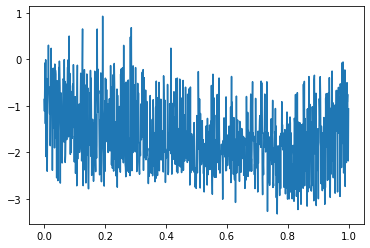

In [648]:
sns.lineplot(torch.linspace(0,1,N), latent_dist_draw[0,0,:])

In [150]:
mean.shape

torch.Size([1000, 6])

ValueError: x and y must be the same size

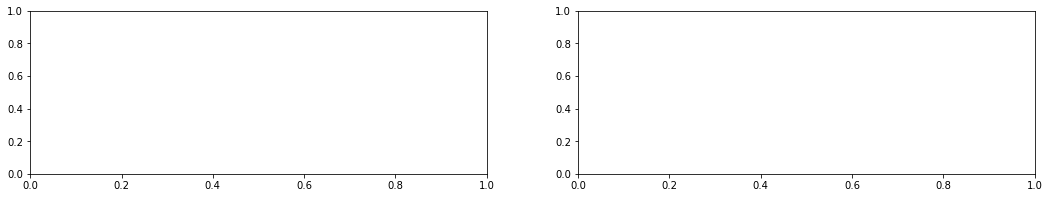

In [465]:
func.plot

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [433]:
lmc_coefficients.abs()

tensor([[0.2976, 0.6633, 0.2556, 0.1816, 0.1623, 0.0214],
        [1.4409, 0.1154, 0.4777, 2.1622, 1.5481, 0.2113]])

In [455]:
(lmc_coefficients / lmc_coefficients.norm(dim=0)).abs()

tensor([[0.2023, 0.9852, 0.4718, 0.0837, 0.1043, 0.1005],
        [0.9793, 0.1714, 0.8817, 0.9965, 0.9945, 0.9949]])

In [234]:
torch.matmul(torch.matmul(model.covar_module.kernel_modules[1].kernels[1].forward(torch.linspace(0,1,100).expand(2,100).T.cuda(), train_x.cuda()).detach(),
             torch.linalg.inv(model.covar_module.kernel_modules[1].kernels[1].forward(train_x.cuda(), train_x.cuda()).detach())),
             train_y.cuda())

tensor([[ 1.9621e+02, -1.0749e+02, -1.0018e+01,  1.6380e+01],
        [-2.6241e+02, -9.1127e+01, -7.1448e+01,  6.1492e+01],
        [-8.5248e+02,  7.0574e+01,  1.2827e+02, -2.6106e+01],
        [ 5.6284e+02, -1.1733e+02, -2.1688e+02,  9.3123e+01],
        [-1.4093e+02, -3.0901e+01, -2.1194e+02,  2.7963e+01],
        [-5.1517e+02, -5.7495e+00, -7.1203e+01,  1.5318e+00],
        [-1.0719e+03, -4.9065e+00, -2.5408e+02, -3.9783e+01],
        [ 4.5269e+01, -1.6458e+02, -1.4053e+02,  1.3965e+01],
        [ 2.9809e+01, -2.7801e+01, -1.6584e+01,  2.1681e+01],
        [-6.2085e+02,  4.2958e+01, -1.6339e+02, -4.3333e+01],
        [-9.4787e+02,  1.2127e+02, -1.5985e+01, -4.8742e+01],
        [ 2.4112e+02, -8.5392e+00,  1.9639e+02, -5.9374e+01],
        [-4.5770e+02,  1.9142e+02,  3.6580e+02, -6.6735e+01],
        [-1.5542e+02,  3.0391e+01, -1.1079e+01, -1.5246e+01],
        [-2.1070e+03,  2.0609e+02,  3.7545e+02, -1.1480e+02],
        [ 3.1772e+02, -7.4701e+01, -1.3880e+02,  7.8373e+00],
        

In [215]:
torch.linalg.inv(model.covar_module.kernel_modules[1].kernels[1].forward(train_x.cuda(), train_x.cuda()).detach())

tensor([[ -20646.3496,   28245.0352,   -7681.4888,  ...,   21476.1387,
         -142824.0156,  127749.0547],
        [ -37323.1016,  194033.0938,   -7293.6289,  ...,   92760.3984,
           20489.0742,  382911.3750],
        [ -62863.7227,   43918.6094,  -53302.2695,  ...,   19698.1191,
           66279.1562,   29607.1211],
        ...,
        [   5316.9790,   56970.0391,   59390.2539,  ...,   61759.0039,
          -16879.7695,   58444.3516],
        [ -43380.5664,  119241.5781,  -21799.4648,  ...,   61595.2930,
         -172870.6250,  258117.0156],
        [  31855.6680,   31031.0957,  -47980.4336,  ...,   33687.1719,
           40162.4688,   74709.0000]], device='cuda:0')

In [210]:
model.covar_module.kernel_modules[1].kernels[1].forward(train_x.cuda(), torch.linspace(0,1,100).expand(2,100).T.cuda()).detach().shape

torch.Size([1000, 100])

In [203]:
model.covar_module.kernel_modules[1].kernels[1].forward(torch.linspace(0,1,100).expand(2,100).T.cuda(), train_x.cuda()).detach().shape

torch.Size([100, 1000])

In [169]:
model.covar_module.kernel_modules[1].kernels[1].lengthscale

tensor([[0.9802, 0.2859]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [113]:
super()

TypeError: super() argument 1 must be type, not LMCVariationalStrategy

In [103]:
type(model.variational_strategy)

__main__.LMCVariationalStrategy

In [111]:
model.variational_strategy.__call__?

Signature:
model.variational_strategy.__call__(
    x,
    task_indices=None,
    prior=False,
    **kwargs,
)
Docstring:
Computes the variational (or prior) distribution
:math:`q( \mathbf f \mid \mathbf X)` (or :math:`p( \mathbf f \mid \mathbf X)`).
There are two modes:

1.  Compute **all tasks** for all inputs.
    If this is the case, the task_indices attribute should be None.
    The return type will be a (... x N x num_tasks)
    :class:`~gpytorch.distributions.MultitaskMultivariateNormal`.
2.  Compute **one task** per inputs.
    If this is the case, the (... x N) task_indices tensor should contain
    the indices of each input's assigned task.
    The return type will be a (... x N)
    :class:`~gpytorch.distributions.MultivariateNormal`.

:param x: Input locations to evaluate variational strategy
:type x: torch.Tensor (... x N x D)
:param task_indices: (Default: None) Task index associated with each input.
    If this **is not** provided, then the returned distribution evaluate

In [108]:
super(type(model.variational_strategy))

<super: __main__.LMCVariationalStrategy, None>

In [98]:
model.variational_strategy.__call__(train_x.cuda(), **{"inducing_values":model.variational_strategy.variational_distribution.mean})

TypeError: gpytorch.module.Module.__call__() got multiple values for keyword argument 'inducing_values'

In [90]:
model.__call__(train_x.cuda(), inducing_values=model.variational_strategy.variational_distribution.mean)

TypeError: gpytorch.module.Module.__call__() got multiple values for keyword argument 'inducing_values'

In [84]:
model.variational_strategy(train_x.cuda(), inducing_values=model.variational_strategy.variational_distribution.mean)

TypeError: gpytorch.module.Module.__call__() got multiple values for keyword argument 'inducing_values'

In [674]:
# additive(product(kernels))
for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_lengthscale Parameter containing:
tensor([[-1.0279, -1.2727]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[-3.1001]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[-3.2494,  7.7436]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.kernels.1.raw_lengthscale Parameter containing:
tensor([[2.0656, 9.6590]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.kernels.1.raw_period_length Parameter containing:
tensor([[2.3995, 9.3742]], device='cuda:0', requires_grad=True)


In [624]:
# active_dims = [2] for kernel_modules.1.kernels.0.raw_lengthscale
for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_lengthscale Parameter containing:
tensor([[-0.9088, -0.7308]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[1.2634]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_lengthscale Parameter containing:
tensor([[-1.2638,  0.9277]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_period_length Parameter containing:
tensor([[0.1018, 1.2464]], device='cuda:0', requires_grad=True)


In [601]:
# ard_num_dims = 2
for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_lengthscale Parameter containing:
tensor([[-0.8014,  0.8889]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.0.raw_lengthscale Parameter containing:
tensor([[3.9538, 4.0094]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_lengthscale Parameter containing:
tensor([[-1.9631,  0.1536]], device='cuda:0', requires_grad=True)
kernel_modules.1.kernels.1.raw_period_length Parameter containing:
tensor([[ 0.1112, -0.4233]], device='cuda:0', requires_grad=True)


In [171]:
# ard_num_dims = 1

for n, p in model.covar_module.named_parameters():
    print(n, p)

kernel_modules.0.raw_outputscale Parameter containing:
tensor(-1.2919, device='cuda:0', requires_grad=True)
kernel_modules.0.base_kernel.raw_lengthscale Parameter containing:
tensor([[-1.0921]], device='cuda:0', requires_grad=True)
kernel_modules.1.raw_outputscale Parameter containing:
tensor(-0.9076, device='cuda:0', requires_grad=True)
kernel_modules.1.base_kernel.raw_lengthscale Parameter containing:
tensor([[-2.8909]], device='cuda:0', requires_grad=True)
kernel_modules.1.base_kernel.raw_period_length Parameter containing:
tensor([[2.7322]], device='cuda:0', requires_grad=True)


In [305]:
model.covar_module.base_kernels[0].base_kernel.lengthscale

tensor([[0.5366]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [306]:
model.covar_module.base_kernels[1].base_kernel.lengthscale

tensor([[0.4790]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [307]:
model.covar_module.base_kernels[1].base_kernel.period_length

tensor([[0.7506]], device='cuda:0', grad_fn=<SoftplusBackward0>)

In [308]:
for n, p in model.named_parameters():
    print("name:", n)
    print("parameter:", p)
    print("\n")

name: variational_strategy.lmc_coefficients
parameter: Parameter containing:
tensor([[ 1.0907, -0.5130,  0.9489, -0.0432, -0.0740, -0.1966],
        [-0.0134,  0.1573, -0.0139,  0.8519,  0.8607,  0.0806]],
       device='cuda:0', requires_grad=True)


name: variational_strategy.base_variational_strategy.inducing_points
parameter: Parameter containing:
tensor([[-0.0752],
        [-0.0793],
        [ 0.0260],
        [ 0.0257],
        [ 0.0257],
        [ 0.0261],
        [-0.0772],
        [-0.0773],
        [-0.0774],
        [-0.0775],
        [ 0.0262],
        [ 0.0279],
        [ 0.0263],
        [ 0.1749],
        [-0.0775],
        [ 0.0269],
        [ 0.0284],
        [ 0.0262],
        [ 0.0264],
        [ 0.0264],
        [ 0.0275],
        [ 0.0265],
        [ 0.0273],
        [ 0.0270],
        [ 0.0271],
        [ 0.0284],
        [ 0.0305],
        [ 0.0274],
        [ 0.0279],
        [ 0.0280],
        [ 0.2491],
        [ 0.0273],
        [ 0.0272],
        [ 0.1749],


In [402]:
with torch.no_grad():
    lmc_coefficients = model.variational_strategy.lmc_coefficients
    lmc_coefficients = lmc_coefficients.cpu()

# A_hat = torch.divide(A_hat.T, torch.norm(A_hat, dim=-1)).T

In [409]:
(A * scale_adj).T

tensor([[ 0.8000, -6.7200, -2.9120,  0.1600,  0.1600,  0.8000],
        [-0.2600, -0.0250,  0.1250,  0.5500,  0.5500,  0.0500]])

In [421]:
lmc_coefficients

tensor([[-0.2976, -0.6633, -0.2556,  0.1816,  0.1623,  0.0214],
        [-1.4409, -0.1154,  0.4777,  2.1622,  1.5481,  0.2113]])

In [418]:
A.T

tensor([[-0.2500,  2.1000,  0.9100, -0.0500, -0.0500, -0.2500],
        [-0.5200, -0.0500,  0.2500,  1.1000,  1.1000,  0.1000]])

In [420]:
(lmc_coefficients.T * scale_adj).T

tensor([[ 0.9523,  2.1226,  0.8179, -0.5811, -0.5194, -0.0683],
        [-0.7204, -0.0577,  0.2388,  1.0811,  0.7741,  0.1057]])

In [422]:
def eigen(lmc_coefficients, norm=True, round=5):
    
    V_mat = lmc_coefficients.T @ lmc_coefficients
    if norm:
        V_mat = torch.divide(V_mat, torch.norm(V_mat, dim=-1).unsqueeze(-1))
    V_eigval, V_eigvec = np.linalg.eig(V_mat)
    idx_sort = np.argsort(V_eigval)[::-1]
    V_eigval, V_eigvec = V_eigval[idx_sort], V_eigvec[:,idx_sort]
    V_eigval, V_eigvec = np.round(V_eigval, round), np.round(V_eigvec, round)

    return V_eigval, V_eigvec

In [423]:
V_mat = lmc_coefficients.T @ lmc_coefficients
V_eigval, V_eigvec = np.linalg.eig(V_mat)

<AxesSubplot:>

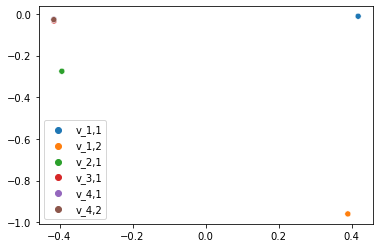

In [424]:
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
eigval, eigvec = eigen(lmc_coefficients, norm=True)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

<AxesSubplot:>

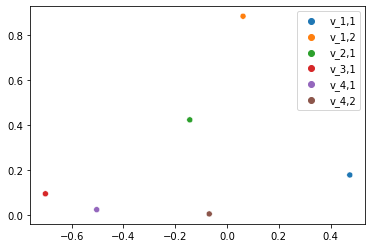

In [425]:
labels = ["v_1,1", "v_1,2", "v_2,1", "v_3,1", "v_4,1", "v_4,2"]
eigval, eigvec = eigen(lmc_coefficients, norm=False)
sns.scatterplot(eigvec[:,0], eigvec[:,1], hue=labels)

In [359]:
latent_dist.lazy_covariance_matrix

In [367]:
lmc_factor = RootLinearOperator(lmc_coefficients.unsqueeze(-1))

In [380]:
latent_dist.lazy_covariance_matrix.cpu()

In [382]:
covar = KroneckerProductLinearOperator(latent_dist.lazy_covariance_matrix.cpu(), lmc_factor).sum(-1)

In [450]:
covar.shape

torch.Size([2, 6000])

In [456]:
(covar.T @ covar).shape

torch.Size([6000, 6000])

In [390]:
latent_dist.lazy_covariance_matrix.shape

torch.Size([2, 1000, 1000])

In [387]:
covar[0].shape

torch.Size([6000])

In [215]:
x_multi = torch.randn([500, 3])
init_covar_x = torch.randn([1, 500, 500])
covar_x = torch.randn([2, 1, 500, 500])
x1 = torch.randn([500,1])
x2 = torch.randn([1,500,1])

In [229]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0, 2]))

In [230]:
kernel._

OrderedDict([('raw_outputscale',
              Parameter containing:
              tensor(0., requires_grad=True))])

In [217]:
test = kernel(x_multi).evaluate_kernel()
test.shape

torch.Size([500, 500])

In [287]:
kernel = LMCKernel(
    [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=3, active_dims=[0, 7000])),
     gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel(active_dims=[0, 2]))],
    batch_shape=2
)

In [288]:
test = kernel(x).evaluate_kernel()
test.shape

params: {'last_dim_is_batch': False}
init_x_shape: torch.Size([500, 1])
x_shape: torch.Size([1, 500, 1])
init_covar_x.shape: torch.Size([1, 500, 500])
kernel: ScaleKernel(
  (base_kernel): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
  (raw_outputscale_constraint): Positive()
)
covar_x.shape: torch.Size([2, 500, 500])


torch.Size([2, 500, 500])

In [244]:
kernel_list = [gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=[0, 2])),
     gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())]

kernel = torch.nn.ModuleList(
    kernel_list
)

In [246]:
kernel[0](x_multi).evaluate_kernel().shape

torch.Size([500, 500])

In [398]:
num_latents=2
num_tasks=6
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(batch_shape=torch.Size([num_latents])), 
                                batch_shape=torch.Size([num_latents])) + \
                        gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.PeriodicKernel(batch_shape=torch.Size([num_latents])),
                            batch_shape=torch.Size([num_latents]))

# torch.Size([2, 1000, 1000]) # CORRECT!                        
# kernel(train_x).shape

torch.Size([2, 1000, 1000])

In [396]:
kernel = gpytorch.kernels.LCMKernel(
                            [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()],
                            num_tasks=num_tasks
                        )

# torch.Size([6000, 6000]) # WRONG!
# kernel(train_x).shape

In [642]:
kernel_list = torch.nn.ModuleList([gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()])

In [643]:
kernel1 = kernel_list[0](train_x.cpu(), train_x.cpu()).evaluate()
kernel2 = kernel_list[1](train_x.cpu()).evaluate()

In [671]:
kernel1.shape

torch.Size([1000, 1000])

In [680]:
torch.concat([kernel1, kernel2]).shape

torch.Size([2000, 1000])

In [669]:
torch.vstack([kernel1, kernel2]).shape

torch.Size([2000, 1000])

In [652]:
torch.vstack([kernel1, kernel2], dim=0).shape

torch.Size([2, 1000, 1000])

In [645]:
kernel1.shape

torch.Size([1000, 1000])

In [424]:
torch.stack([kernel1, kernel2]).shape

torch.Size([2, 1000, 1000])

In [459]:
kernel_list

ModuleList(
  (0): RBFKernel(
    (raw_lengthscale_constraint): Positive()
    (distance_module): Distance()
  )
  (1): PeriodicKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_period_length_constraint): Positive()
    (distance_module): Distance()
  )
)

In [482]:
gpytorch.kernels.kernel.Kernel

gpytorch.kernels.kernel.Kernel

In [504]:
torch.empty(len(kernel_list),len(train_x)).shape

torch.Size([2, 1000])

In [549]:
torch.stack([covar_x, covar_x, covar_x])

tensor([[-9.4344e+17,  4.5604e-41],
        [-9.4344e+17,  4.5604e-41],
        [-9.4344e+17,  4.5604e-41]])

In [629]:
kernel_list = [gpytorch.kernels.RBFKernel(),
                            gpytorch.kernels.PeriodicKernel()]

kernel = LMCKernel(kernel_list, batch_shape=torch.Size([num_latents]))

In [630]:
kernel(train_x.cpu()).evaluate_kernel().shape

torch.Size([2, 1000, 1000])


torch.Size([2, 1000, 1000])